In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.cluster import KMeans, SpectralClustering
from scipy.cluster import hierarchy as h
from pyclustering.cluster.kmedoids import kmedoids
import pandas as pd
import numpy as np
from random import sample
from collections import defaultdict
import re
from nltk.corpus import stopwords
import gensim
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from analysisTools import load_tweets, clean,freq_dicts, sort_freq_dict, keyword_search, keyword_analysis 


In [227]:
try:
    print('Attempting to load vectors from file.')
    word2vec = gensim.models.KeyedVectors.load('wordvecs.txt', mmap='r')
    print("Text file found.")
except IOError:
    print("File not found. Extracting from binary and processing.")
    word2vec = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
    print('Writing results to file for later use.')
    word2vec.init_sims(replace=True)
    word2vec.save('wordvecs.txt')
print("Loaded word vectors successfully!")

Attempting to load vectors from file.
Text file found.
Loaded word vectors successfully!


In [283]:
USER = '_@user_'
HTTP = '_web_'

filter_words = set(['chinese', 'virus', 'wuhan', 'china', 'coronavirus' , 'rt', USER, HTTP,
                     'covid', '19' 'covid19'])

def gen_tweet_vector(tweet):    
    tweet = [w for w in tweet if w in word2vec.vocab]
    if len(tweet) > 0:
        vecs = np.stack([word2vec.get_vector(w) for w in tweet if w in word2vec.vocab])
        return vecs.sum(0)
    else:
        return None

def cluster_partition(clustering, tweets, csv=False, name_fn=None):
    clusters = defaultdict(list)

    for i, cluster in enumerate(f):
        clusters[cluster].append(' '.join(tweets[i]))
    
    if csv:
        for cluster, tweets in clusters.items():
            ts = np.array(tweets)
            fname = name_fn(str(cluster))
            np.savetxt(fname, ts, fmt ='%s')
            print('successfully saved %s' %fname)
    
    return clusters

In [229]:
tweets = load_tweets('tweet_data.csv')
tweets_clean = clean(tweets)


In [230]:
hashtags, words = freq_dicts(tweets_clean)

In [250]:
hashtag_counts = sort_freq_dict(hashtags)
word_counts = sort_freq_dict(words)

#print(word_counts)

In [232]:
coronavirus = '#coronavirus'
chinese_virus = '#chinesevirus'
wuhan_virus = '#wuhanvirus'
covid19 = '#covid19'

hts = [ coronavirus, chinese_virus, wuhan_virus, covid19]

In [235]:
keyword_results = [keyword_analysis(tweets_clean, ht) for ht in hts]

coronavirus_words = set([wc[0] for wc in keyword_results[0][1] if wc[1] > 1])
chinese_virus_words = set([wc[0] for wc in keyword_results[1][1]])
covid19_words = set([wc[0] for wc in keyword_results[3][1]])

'''print(keyword_results[0][0])
print('\n')
print(keyword_results[1][0])
print('\n')
print(keyword_results[2][0])
print('n')
print(keyword_results[3][0])'''

"print(keyword_results[0][0])\nprint('\n')\nprint(keyword_results[1][0])\nprint('\n')\nprint(keyword_results[2][0])\nprint('n')\nprint(keyword_results[3][0])"

In [236]:
venn = (covid19_words - chinese_virus_words, chinese_virus_words - covid19_words)
#print(venn[0])

In [284]:
tweet_vecs = [gen_tweet_vector(tweet) for tweet in tweets_clean]
tweet_vecs = np.stack([tweet for tweet in tweet_vecs if tweet is not None])


In [285]:
# Testing different numbers of dimensions to maintain
D = pairwise_distances(tweet_vecs, metric="cosine")

mds2 = MDS(n_components=2, dissimilarity='precomputed')
tweet_emb2 = mds2.fit_transform(D)
#print('num dimensions: %d ---> stress: %f' %(2, transform.stress_))

(6316, 6316)
(6316, 2)


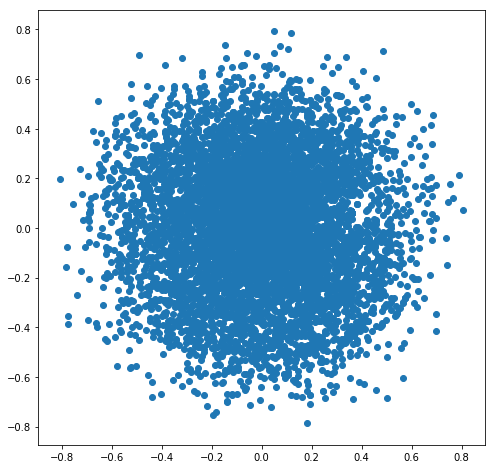

In [288]:
print(D.shape)
print(tweet_emb2.shape)
plt.figure(figsize=(8,8))
plt.scatter(tweet_emb2[:, 0], tweet_emb2[:, 1])

/Users/nicksempere/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


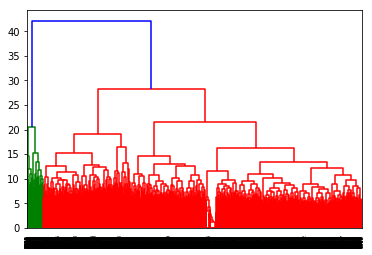

In [289]:
_hierarchy = np.array(h.linkage(D, method='complete'))

try:
    h.dendrogram(_hierarchy)
except:
    '''supressing weird native error in h.dendrogram'''

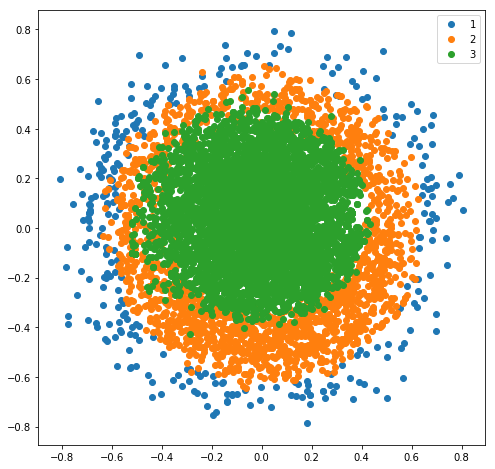

In [292]:
f = np.array(h.fcluster(_hierarchy, 25, criterion='distance'))
f_clusters = len(set(f))
test = plt.figure(figsize=(8,8))

cps = []
for i in range(0, f_clusters):
    cp = plt.scatter(tweet_emb2[f == i+1, 0], tweet_emb2[f == i+1, 1], label=str(i+1))
    cps.append(cp)

plt.legend(handles=cps)


    


In [293]:
h_clustering = defaultdict(list)

h_partition = cluster_partition(h_clustering, tweets, csv=True, name_fn=lambda c: 'hierarchy_{}_clust.csv'.format(str(c)))


successfully saved hierarchy_2_clust.csv
successfully saved hierarchy_3_clust.csv
successfully saved hierarchy_1_clust.csv


In [297]:
nerds = np.array(['sachi', 'shreya', 'camyll', 'jack', 'antonio', 'anu', 'teffie', 'zack', 'nick', 'irene'])

list(np.random.choice(nerds, size=5, replace=False))

['antonio', 'irene', 'teffie', 'nick', 'shreya']

['shreya', 'camyll', 'nick', 'sachi']

In [240]:
kmeds = kmedoids(D, [40, 1, 10, 25, 8, 15, 32])
kmeds.process()
kmeds_clusters = kmeds.get_clusters()


IndexError: index 3200 is out of bounds for axis 0 with size 3200

<Figure size 576x576 with 0 Axes>

successfully saved kmeds_1_clust.csv
successfully saved kmeds_5_clust.csv
successfully saved kmeds_6_clust.csv
successfully saved kmeds_2_clust.csv
successfully saved kmeds_3_clust.csv
successfully saved kmeds_4_clust.csv


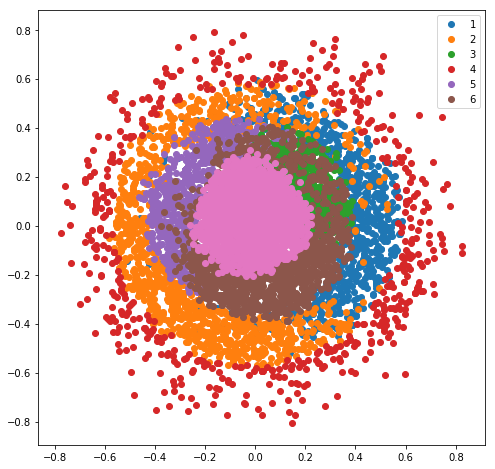

In [262]:
plt.figure(figsize=(8,8))

for i, cluster in enumerate(kmeds_clusters):
    plt.scatter(tweet_emb2[cluster, 0], tweet_emb2[cluster, 1], label=str(i+1))

plt.legend(handles=cps)

kmeds_partition = cluster_partition(kmeds_clusters, tweets, csv=True, name_fn=lambda c: 'kmeds_{}_clust.csv'.format(str(c)))


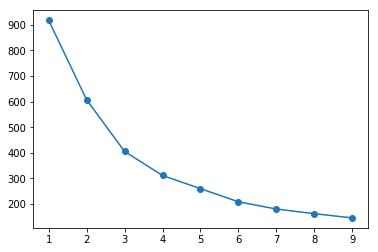

In [261]:
spec = SpectralClustering(n_clusters=6)

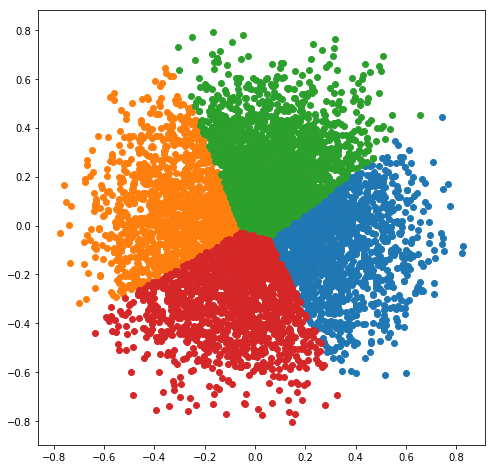